In [1]:
!pip install pytorch_model_summary

In [2]:

import random
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as Acivation
from sklearn.model_selection import train_test_split

from torch import nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

from pytorch_model_summary import summary

device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/work1/tdata.zip', 'r')
file = zip_ref.extractall("./tmp")
zip_ref.close()

print("o")

o


In [5]:
DATASET="/content/tmp/tdata/train"
DATASET2="/content/tmp/tdata/valid"

In [6]:
CATEGORIES=["Tomato___Bacterial_spot","Tomato___Early_blight","Tomato___healthy","Tomato___Late_blight","Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot","Tomato___Spider_mites Two-spotted_spider_mite","Tomato___Target_Spot","Tomato___Tomato_mosaic_virus","Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
        
train_data=[]

In [7]:
import os
import tensorflow as tf

import cv2
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(224,224))            
            train_data.append([img,label])
            
test_data=[]

In [8]:
for category in CATEGORIES:
        label=CATEGORIES.index(category)
        path=os.path.join(DATASET2,category)
        for img_file in os.listdir(path):
            img=cv2.imread(os.path.join(path,img_file),1)
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img=cv2.resize(img,(224,224))
            test_data.append([img,label])
            
print(len(train_data))
print(len(test_data))

18345
4585


In [9]:
random.shuffle(train_data)
random.shuffle(test_data)

In [10]:
for lbl in train_data[:10]:
    print(lbl[1])
    
X_train=[]
y_train=[]

5
8
5
7
2
9
5
5
0
5


In [11]:
for features,label in train_data:
    X_train.append(features)
    y_train.append(label)

In [12]:
Y=[]
for i in y_train:
    if i==0:
        Y.append("BACTERIAL SPOT")
    elif i==1:
        Y.append("EARLY BLIGHT")
    elif i==2:
        Y.append("HEALTHY")
    elif i==3:
        Y.append("LATE BLIGHT")
    elif i==4:
        Y.append("LEAF MOLD")
    elif i==5:
        Y.append("SEPTORIA LEAF SPOT")
    elif i==6:
        Y.append("SPIDER MITE")
    elif i==7:
        Y.append("TARGET SPOT")
    elif i==8:
        Y.append("MOSAIC VIRUS")
    else:
        Y.append("YELLOW LEAF CURL VIRUS")

In [13]:
len(X_train),len(y_train)

(18345, 18345)

In [14]:
X_test=[]
y_test=[]

In [15]:
for features,label in test_data:
    X_test.append(features)
    y_test.append(label)
    
Z=[]
for i in y_test:
    if i==0:
        Z.append("BACTERIAL SPOT")
    elif i==1:
        Z.append("EARLY BLIGHT")
    elif i==2:
        Z.append("HEALTHY")
    elif i==3:
        Z.append("LATE BLIGHT")
    elif i==4:
        Z.append("LEAF MOLD")
    elif i==5:
        Z.append("SEPTORIA LEAF SPOT")
    elif i==6:
        Z.append("SPIDER MITE")
    elif i==7:
        Z.append("TARGET SPOT")
    elif i==8:
        Z.append("MOSAIC VIRUS")
    else:
        Z.append("YELLOW LEAF CURL VIRUS")

In [16]:
len(X_test),len(y_test)

(4585, 4585)

In [17]:
import numpy as np
X_train=np.array(X_train).reshape(-1, 224,224,3)
X_train.shape

(18345, 224, 224, 3)

In [18]:
X_test=np.array(X_test).reshape(-1, 224,224,3)
X_test.shape

(4585, 224, 224, 3)

In [19]:
y_train[:2], y_test[:2]

([5, 8], [2, 8])

In [20]:
X_test.shape

(4585, 224, 224, 3)

In [21]:
class TOMATO_DATASET(Dataset):

    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        self.len = len(x)

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        x_batch = self.x[index]
        y_batch = self.y[index]

        if self.transform is not None:
            x_batch = self.transform(x_batch)
        
        y_batch = torch.from_numpy(np.array(y_batch))

        return x_batch, y_batch


In [22]:

transform1 = transforms.Compose([
    #transforms.Resize(224, 224),
    transforms.ToTensor(),
    transforms.Normalize( (0.5, ), (0.5, ) )
])


train_dataset = TOMATO_DATASET(X_train, y_train, transform=transform1)
valid_dataset = TOMATO_DATASET(X_test, y_test, transform=transform1)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)



dataiter = iter(valid_loader)
images, label = dataiter.next()

print(images.shape, label.shape)


torch.Size([100, 3, 224, 224]) torch.Size([100])


In [23]:

class CNN(nn.Module):

    def __init__(self,vgg_features):
        super().__init__()

        self.features = vgg_features
        self.FLAT = nn.Flatten()

        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 128),
            nn.ReLU(),
            nn.Linear(128, 10)

        )

    def forward(self, z):
        z = self.features(z)
        z = self.FLAT(z)
        z = self.classifier(z)

        return z


In [24]:
vgg_f =  models.vgg16(pretrained=True).features

model = CNN(vgg_f).to(device)

# show output shape
# print(summary(model, torch.zeros((1, 3, 64, 64)), show_input=False))

In [25]:

# loss function and optimizer
model_loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# training
loss_history = []
acc_history =  []
val_acc_history = []
val_loss_history = []
EPOCHS = 20

for e in range(EPOCHS):
    batch_loss = 0.0
    batch_acc = 0.0

    val_batch_loss = 0.0
    val_batch_acc = 0.0

    i = 0
    for x_bacth, y_batch in train_loader:
        i = i + 1
        optimizer.zero_grad() # set gradient to zero

        x_train = x_bacth #x_bacth.view(x_bacth.shape[0], -1)
        # print(x_bacth.shape, x_train.shape)
        x_train = x_bacth.to(device) #x_bacth.view(x_bacth.shape[0], -1)
        y_batch = y_batch.to(device)
        y_pred = model.forward(x_train)
        loss = model_loss(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(y_pred, 1)
        batch_loss = batch_loss + loss / len(train_loader)
        batch_acc = batch_acc + torch.sum(preds == y_batch.data) / ( len(train_loader) * 100 )

        print('Epoch: {} & Iteration: {} ~ = batch_loss: {:.4f}, batch_acc: {:.4f}'.format(e+1,i, batch_loss, batch_acc.item()))

    with torch.no_grad():
        i = 0
        for x_val, y_val in valid_loader:
            i = i+1
            # x_val =  x_val.view(x_val.shape[0], -1)
            x_val = x_val.to(device) #x_bacth.view(x_bacth.shape[0], -1)
            y_val = y_val.to(device)

            y_pred = model.forward(x_val)
            val_loss = model_loss(y_pred, y_val)

            _, preds = torch.max(y_pred, 1)
            val_batch_loss = val_batch_loss + val_loss / len(valid_loader)
            val_batch_acc = val_batch_acc + torch.sum(preds == y_val.data) / (len(valid_loader) * 100)

            print('Epoch: {} & Iteration: {} ~ = val batch_loss: {:.4f}, val batch_acc: {:.4f}'.format(e+1,i, val_batch_loss, val_batch_acc.item()))




    epoch_loss = batch_loss
    epoch_acc = batch_acc.float()
    val_epoch_loss = val_batch_loss
    val_epoch_acc = val_batch_acc.float()

    loss_history.append(epoch_loss)
    acc_history.append(epoch_acc)
    val_acc_history.append(val_epoch_acc)
    val_loss_history.append(val_epoch_loss)
    print('Epoch: {},~ = training_loss: {:.4f}, training_acc: {:.4f}; val_loss: {:.4f}, val_acc: {:.4f}'.format(e+1, epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))


Epoch: 1 & Iteration: 1 ~ = batch_loss: 0.0125, batch_acc: 0.0005
Epoch: 1 & Iteration: 2 ~ = batch_loss: 0.0249, batch_acc: 0.0016
Epoch: 1 & Iteration: 3 ~ = batch_loss: 0.0374, batch_acc: 0.0019
Epoch: 1 & Iteration: 4 ~ = batch_loss: 0.0493, batch_acc: 0.0029
Epoch: 1 & Iteration: 5 ~ = batch_loss: 0.0607, batch_acc: 0.0046
Epoch: 1 & Iteration: 6 ~ = batch_loss: 0.0707, batch_acc: 0.0073
Epoch: 1 & Iteration: 7 ~ = batch_loss: 0.0800, batch_acc: 0.0097
Epoch: 1 & Iteration: 8 ~ = batch_loss: 0.0883, batch_acc: 0.0122
Epoch: 1 & Iteration: 9 ~ = batch_loss: 0.0973, batch_acc: 0.0147
Epoch: 1 & Iteration: 10 ~ = batch_loss: 0.1041, batch_acc: 0.0178
Epoch: 1 & Iteration: 11 ~ = batch_loss: 0.1104, batch_acc: 0.0208
Epoch: 1 & Iteration: 12 ~ = batch_loss: 0.1157, batch_acc: 0.0245
Epoch: 1 & Iteration: 13 ~ = batch_loss: 0.1219, batch_acc: 0.0277
Epoch: 1 & Iteration: 14 ~ = batch_loss: 0.1268, batch_acc: 0.0316
Epoch: 1 & Iteration: 15 ~ = batch_loss: 0.1321, batch_acc: 0.0352
Epoc

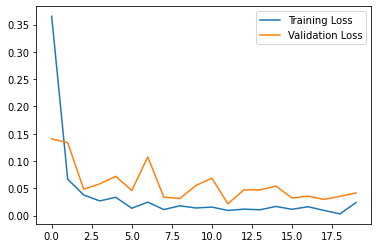

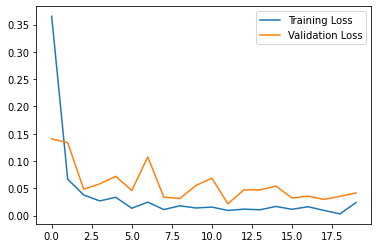

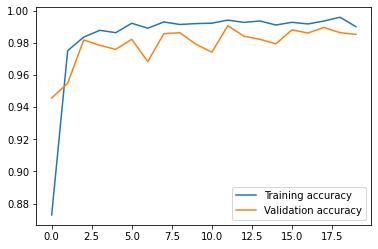

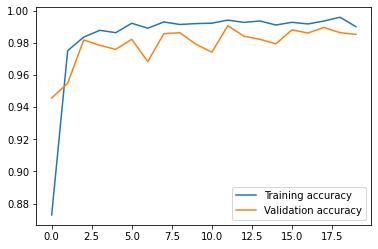

In [26]:
import matplotlib.pyplot as plt


plt.plot(loss_history,label='Training Loss')  
plt.plot(val_loss_history,label='Validation Loss')  
plt.legend()  
plt.show()  
plt.plot(acc_history,label='Training accuracy')  
plt.plot(val_acc_history,label='Validation accuracy')  
plt.legend()  
plt.show()  

In [27]:
# loss_history = []
# acc_history =  []
# val_acc_history = []
# val_loss_history = []

In [30]:
PATH = '/content/drive/MyDrive/work1/model_weights.pth'
torch.save(model, PATH)

In [31]:
from PIL import Image

# compose allow us to chain multiple transform together
transform1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))

])

CATEGORIES=["Tomato___Bacterial_spot","Tomato___Early_blight",
            "Tomato___healthy","Tomato___Late_blight",
            "Tomato___Leaf_Mold","Tomato___Septoria_leaf_spot",
            "Tomato___Spider_mites Two-spotted_spider_mite","Tomato___Target_Spot",
            "Tomato___Tomato_mosaic_virus","Tomato___Tomato_Yellow_Leaf_Curl_Virus"]
        
path = '/content/tmp/tdata/valid/Tomato___Target_Spot/003a5321-0430-42dd-a38d-30ac4563f4ba___Com.G_TgS_FL 8121_newPixel25.JPG'
img = Image.open(path)
# img.shape
img = transform1(img)
img.shape

image = img.view(1,img.shape[0], img.shape[1], img.shape[2])
image.shape


output = model(image.to(device)).to(device)
_,pred=torch.max(output,1)
print(pred[0].item())
print(CATEGORIES[pred[0].item()])

7
Tomato___Target_Spot
